# RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")

print(device)

# Load the dataset
file_path = 'lotka_volterra_data.csv'
df = pd.read_csv(file_path)

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df[['Prey', 'Predator']])

# Convert the dataset to PyTorch tensors
data = torch.FloatTensor(df_scaled).to(device)

mps


In [2]:
# Prepare the dataset for RNN
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

seq_length = 5  # number of previous time steps to consider
train_inout_seq = create_inout_sequences(data, seq_length)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=10, output_size=2):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Using ReLU activation in RNN layer
        self.rnn = nn.RNN(input_size, hidden_layer_size, nonlinearity='relu')

        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size)

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        
        return predictions[-1]

# Instantiate the model, define the loss function and the optimizer
model = RNN().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
# Training the RNN
epochs = 20
losses = []

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    losses.append(single_loss.item())
    
    print(f'epoch: {i} loss: {single_loss.item():10.10f}')

/Users/jasonc/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.5926911235
epoch: 1 loss: 0.2053380460
epoch: 2 loss: 0.0079811448
epoch: 3 loss: 0.0004632971
epoch: 4 loss: 0.0000324554
epoch: 5 loss: 0.0013339480
epoch: 6 loss: 0.0018362468
epoch: 7 loss: 0.0014779778
epoch: 8 loss: 0.0009993077
epoch: 9 loss: 0.0133823156
epoch: 10 loss: 0.0146236010
epoch: 11 loss: 0.0157438535
epoch: 12 loss: 0.0030598151
epoch: 13 loss: 0.0048289043
epoch: 14 loss: 0.0008205826
epoch: 15 loss: 0.0019036969
epoch: 16 loss: 0.0003925238
epoch: 17 loss: 0.0007854794
epoch: 18 loss: 0.0062807780
epoch: 19 loss: 0.0067052711


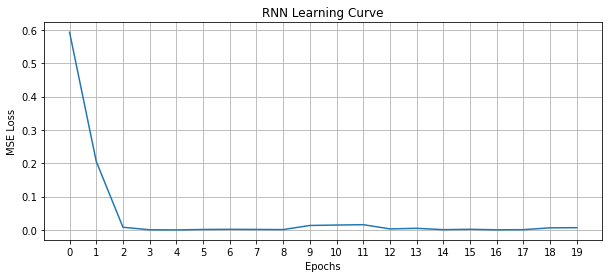

In [4]:
# Plotting the learning curve
plt.figure(figsize=(10,4))
plt.plot(range(epochs), losses)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('RNN Learning Curve')
plt.grid(True)

plt.savefig("Learning Curve.png", dpi = 400)

plt.show()

In [5]:
# Save the trained model
model.to('cpu')
torch.save(model.state_dict(), 'ode_model.pth')

In [6]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

# Assuming the model and the scaler are already defined and trained

# Load the test data
test_df = pd.read_csv('lotka_volterra_data_test.csv')

# Normalize the test data
test_scaled = scaler.transform(test_df[['Prey', 'Predator']])
test_data = torch.FloatTensor(test_scaled).to(device)

# Prepare the test data sequences
test_sequences = create_inout_sequences(test_data, seq_length)

# Evaluate the model
model.eval()  # Set the model to evaluation mode

model.to(device)

test_loss = 0

with torch.no_grad():
    for seq, true_value in test_sequences:
        seq = seq.to(device)
        true_value = true_value.to(device)
        prediction = model(seq)
        test_loss += loss_function(prediction, true_value).item()

test_loss /= len(test_sequences)
print(f'Test Loss: {test_loss}')

/Users/jasonc/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.019700647549899784


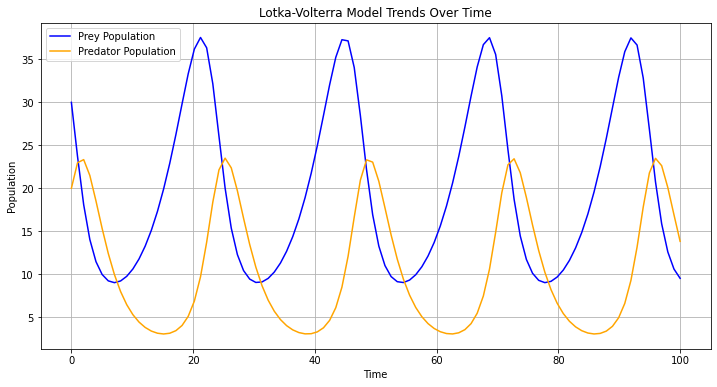

In [7]:
# Plotting the trends over time for the Lotka-Volterra model

plt.figure(figsize=(12, 6))

# Plotting prey and predator populations over time
plt.plot(test_df['Time'], test_df['Prey'], label='Prey Population', color='blue')
plt.plot(test_df['Time'], test_df['Predator'], label='Predator Population', color='orange')

# Plot settings
plt.title('Lotka-Volterra Model Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

plt.show()

/Users/jasonc/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.013863329096133576


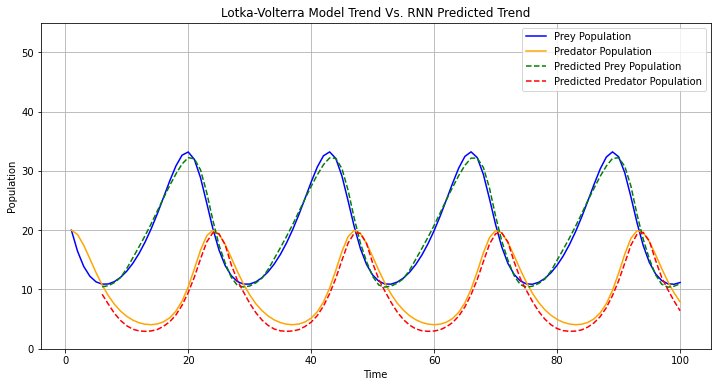

In [8]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import numpy as np

# Assuming the model and the scaler are already defined and trained

# Load the test data
test_df = pd.read_csv('lotka_volterra_data.csv')

# Normalize the test data
test_scaled = scaler.transform(test_df[['Prey', 'Predator']])
test_data = torch.FloatTensor(test_scaled).to(device)

# Prepare the test data sequences
test_sequences = create_inout_sequences(test_data, seq_length)

# Evaluate the model
model.eval()  # Set the model to evaluation mode
model.to(device)

test_loss = 0
predictions = []  # Store model predictions

with torch.no_grad():
    for seq, true_value in test_sequences:
        seq = seq.to(device)
        true_value = true_value.to(device)
        prediction = model(seq)
        test_loss += loss_function(prediction, true_value).item()
        predictions.append(prediction.cpu().numpy())  # Append predictions to the list

test_loss /= len(test_sequences)
print(f'Test Loss: {test_loss}')

# Reshape the predicted_data to a 2D array
predicted_data = np.concatenate(predictions, axis=0).reshape(-1, 2)

# Pad the beginning of predicted_data with NaN values to match the time values' length
num_nan_values = len(test_df['Time']) - len(predicted_data)
if num_nan_values > 0:
    nan_values = np.full((num_nan_values, 2), np.nan)
    predicted_data = np.concatenate([nan_values, predicted_data], axis=0)

# Inverse-transform the scaled predictions back to the original scale
predicted_data = scaler.inverse_transform(predicted_data)

# Plotting the trends over time for the Lotka-Volterra model
plt.figure(figsize=(12, 6))
    
# Plotting prey and predator populations over time
plt.plot(test_df['Time'], test_df['Prey'], label='Prey Population', color='blue')
plt.plot(test_df['Time'], test_df['Predator'], label='Predator Population', color='orange')

# Plotting the model's predicted trend
plt.plot(test_df['Time'], predicted_data[:, 0], label='Predicted Prey Population', linestyle='--', color='green')
plt.plot(test_df['Time'], predicted_data[:, 1], label='Predicted Predator Population', linestyle='--', color='red')

# Plot settings
plt.title('Lotka-Volterra Model Trend Vs. RNN Predicted Trend')
plt.ylim(0,55)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(loc = 'upper right')
plt.grid(True)
    
plt.savefig("RNN Simulation Results.png", dpi = 400)
    
plt.show()